<a href="https://colab.research.google.com/github/deibyrios/Recognize-handwritten-digits/blob/master/Copy_of_hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 >Applied Machine Learning - Homework 5

## Task 1 - Multilayer perceptron with two hidden layers on iris dataset
  
Run a multilayer perceptron with two hidden layers and rectified linear nonlinearities on the iris dataset using the keras Sequential interface. 

Include code for selecting regularization strength and number of hidden units using GridSearchCV and evaluation on an independent test-set.

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import os
from zipfile import ZipFile

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.initializers import glorot_uniform
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [0]:
from keras import backend as K
if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 1.13.1 , GPU: /device:GPU:0


<h4> Let's load the iris dataset and get features and targets:

In [0]:
#from sklearn.datasets import load_iris

iris = load_iris()
feature_names = iris['feature_names']
target_names = iris['target_names']
num_features = len(feature_names)
num_classes = len(target_names)

X = iris['data']
y = iris['target']
y = keras.utils.to_categorical(y, num_classes)

print('Features: ', feature_names)
print('\nTarget Classes :', target_names)

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Target Classes : ['setosa' 'versicolor' 'virginica']


<h4> Let's split data into training and test sets:


In [0]:
#from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=y, random_state=0)
print('No. of training samples :', len(y_train), '\nNo. of test samples :',
      len(y_test))

No. of training samples : 112 
No. of test samples : 38


### Include code for selecting regularization strength and number of hidden units using GridSearchCV:

#### Let's create our keras' scikit-learn model wrapper:

In [0]:
#from keras.models import Sequential
#from keras.layers import Dense
#from keras import regularizers
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.initializers import glorot_uniform

def make_sklearn_mlp(n_features, n_classes, l2_reg=0, hidden_units=8):
  mlp = Sequential([
    Dense(hidden_units, input_shape=(n_features,), activation='relu', 
        kernel_regularizer=regularizers.l2(l2_reg),
        kernel_initializer = glorot_uniform(0)),
    Dense(hidden_units, activation='relu',
        kernel_initializer = glorot_uniform(0)),
    Dense(n_classes, activation='softmax',
        kernel_regularizer=regularizers.l2(l2_reg),
        kernel_initializer = glorot_uniform(0))])
  mlp.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
  return mlp

clf = KerasClassifier(make_sklearn_mlp, n_features=num_features,
                      n_classes=num_classes, epochs=100, batch_size=4, 
                      shuffle=True, verbose=0)
print('keras wrapper object: \n', type(clf))

keras wrapper object: 
 <class 'keras.wrappers.scikit_learn.KerasClassifier'>


#### Let's tune the regularization strength and number of hidden units using GridSearchCV:

In [0]:
#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.model_selection import GridSearchCV

sss = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0)

param_grid = {'l2_reg': np.logspace(-5, -3, 6),
              'hidden_units': [8, 16, 32]}

grid = GridSearchCV(clf, param_grid=param_grid, cv=sss, return_train_score=True)
grid.fit(X_train, y_train)

results = pd.DataFrame(grid.cv_results_)
results.pivot_table(index=["param_l2_reg", "param_hidden_units"],
                values=['mean_train_score', "mean_test_score"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


mean_test_score  mean_train_score
param_l2_reg param_hidden_units                                   
0.000010     8                          0.956522          0.977528
             16                         0.956522          0.988764
             32                         0.956522          0.966292
0.000025     8                          0.956522          0.955056
             16                         0.956522          0.966292
             32                         0.956522          0.977528
0.000063     8                          0.913043          0.977528
             16                         0.956522          0.988764
             32                         0.956522          0.988764
0.000158     8                          0.956522          0.955056
             16                         0.956522          0.977528
             32                         1.000000          0.955056
0.000398     8                          0.956522          0.955056
             16                         0.956522          0.966292
             32                         0.956522          0.955056
0.001000     8                          0.913043          0.977528
             16                         0.956522          0.977528
             32                         0.956522          0.966292

#### From the above, we can see that 16 and 32 hidden units perform ver similar, though 32 units with regularization of 1.58e-4 are the best combination of parameters:


Best Parameters: 
 {'hidden_units': 32, 'l2_reg': 0.00015848931924611142} 




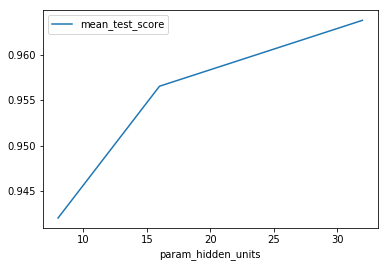

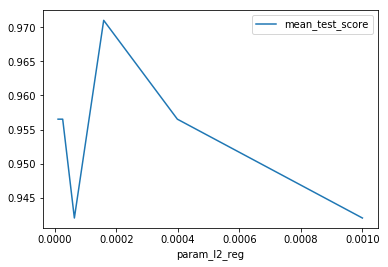

In [0]:
print('\nBest Parameters: \n', grid.best_params_, '\n\n')

results = pd.DataFrame(grid.cv_results_)
results.pivot_table(index=["param_hidden_units"],
                values=["mean_test_score"]).plot()

results.pivot_table(index=["param_l2_reg"],
                values=["mean_test_score"]).plot()

#### Let's train our tuned model on the entire training set (including validation ) and evaluate it on an independent test-set:

In [0]:
best_clf = grid.best_estimator_
best_clf.fit(X_train, y_train)
score = best_clf.score(X_test, y_test)
print("\nTest Accuracy: {:.3f}".format(score))

print('\nNo. of training samples :', len(y_train), '\nNo. of test samples :',
      len(y_test))


Test Accuracy: 1.000

No. of training samples : 112 
No. of test samples : 38


#### We got a test accuraccy of 100%. Though we put apart 25% of the data for test, the dataset size is only 150 samples so the test set is just 38 samples. That may be the reason why we are getting 100% accuracy as it is a very small test set.
<br><br><br>

## Task 2 - Multilayer perceptron on the Fashion MNIST dataset
  
Train a multilayer perceptron (fully connected) on the Fashion MNIST dataset using the traditional train/test split as given by fashion_mnist.load_data in keras. 

Use a separate 10000 samples (from the training set) for model selection and to compute learning curves (accuracy vs epochs, not vs n_samples). 

Compare a “vanilla” model with a model using drop-out (potentially a bigger model), and to a model using batch normalization and residual connections (but not dropout). Visualize learning curves for all models.

#### From the keras datasets [documentation for Fashion-MINST](https://keras.io/datasets/#fashion-mnist-database-of-fashion-articles):


#### Fashion-MNIST database of fashion articles

Dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST. 

**The class labels are:**

Label	Description

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6.	Shirt
7.	Sneaker
8.	Bag
9.	Ankle boot

#### Usage:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#### Returns:
2 tuples:
* x_train, x_test: uint8 array of grayscale image data with shape (num_samples, 28, 28).
* y_train, y_test: uint8 array of labels (integers in range 0-9) with shape (num_samples,).

#### Let's download the data:

In [0]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [0]:
print('\nTraining data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('\nTest data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)

Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


#### Let's visualize a sample of the data:

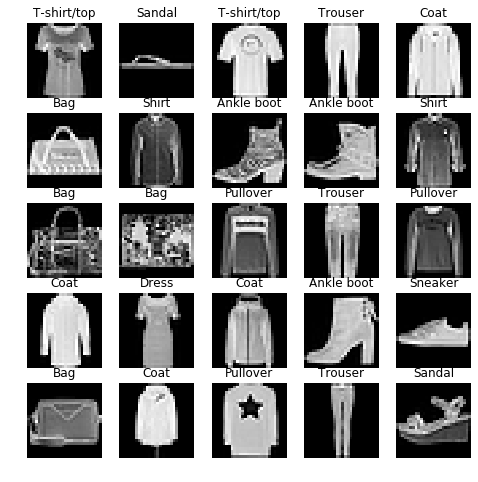

In [0]:
target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#We randomly choose 25 images from the train dataset.
fig, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_train[i], cmap="gray")
        axes1[j][k].set_title(target_names[y_train[i]])

#### Since we will be working with a fully connected MLP, we need to flatten the features.

#### Let's flatten the features and one-hot-encode the targets:

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)

num_classes = len(target_names)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nTraining data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('\nTest data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

print('\nTraining features scale: ', [np.min(X_train), np.max(X_train)])


Training data shape:  (60000, 784)
Training labels shape:  (60000, 10)

Test data shape:  (10000, 784)
Test labels shape:  (10000, 10)

Training features scale:  [0, 255]


#### As we can see above, the pixels are in [0, 255] scale. There is not need to normalize then, but let's just scale to [0, 1]:

In [0]:
X_train, X_test = X_train/255.0, X_test/255.0
print('\nTraining features scale: ', [np.min(X_train), np.max(X_train)])
print('Test features scale: ', [np.min(X_test), np.max(X_test)])


Training features scale:  [0.0, 1.0]
Test features scale:  [0.0, 1.0]


#### Let's separate 10,000 samples (from the training set) as validation set to be used for model selection and to compute learning curves (accuracy vs epochs): 

In [0]:
mask = np.random.permutation(X_train.shape[0])

X_train = X_train[mask]
y_train = y_train[mask]

num_validation = 10000
num_training = X_train.shape[0] - num_validation

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Train data shape:  (50000, 784)
Train labels shape:  (50000, 10)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000, 10)


#### As additional preprocessing: let's subtract the mean value across every dimension for training data:

In [0]:
mean_image = np.mean(X_train, axis=0)
X_train = X_train - mean_image
X_val = X_val - mean_image
X_test = X_test - mean_image

num_features = X_train.shape[1]

print('\nTraining data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)


Training data shape:  (50000, 784)
Validation data shape:  (10000, 784)
Test data shape:  (10000, 784)


### Let's build a baseline model: 

In [0]:
mlp = Sequential([
    Dense(32, input_shape=(num_features,), activation='relu',
         kernel_initializer = glorot_uniform(0)),
    Dense(32, activation='relu',
         kernel_initializer = glorot_uniform(0)),
    Dense(num_classes, activation='softmax',
         kernel_initializer = glorot_uniform(0))])
mlp.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_62 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_63 (Dense)             (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


#### Let's train and validate our baseline model:


Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 13s 267us/step - loss: 0.4811 - acc: 0.8271 - val_loss: 0.3881 - val_acc: 0.8626
Epoch 2/15
50000/50000 [==============================] - 12s 233us/step - loss: 0.3576 - acc: 0.8687 - val_loss: 0.3620 - val_acc: 0.8710
Epoch 3/15
50000/50000 [==============================] - 13s 263us/step - loss: 0.3284 - acc: 0.8788 - val_loss: 0.3640 - val_acc: 0.8698
Epoch 4/15
50000/50000 [==============================] - 12s 232us/step - loss: 0.3094 - acc: 0.8856 - val_loss: 0.3480 - val_acc: 0.8783
Epoch 5/15
50000/50000 [==============================] - 12s 232us/step - loss: 0.2928 - acc: 0.8909 - val_loss: 0.3479 - val_acc: 0.8754
Epoch 6/15
50000/50000 [==============================] - 12s 232us/step - loss: 0.2788 - acc: 0.8966 - val_loss: 0.3360 - val_acc: 0.8807
Epoch 7/15
50000/50000 [==============================] - 12s 232us/step - loss: 0.2672 - acc: 0.8999 - val_loss: 0.

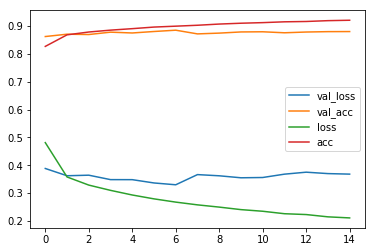

In [0]:
history_callback = mlp.fit(X_train, y_train, batch_size=16, epochs=15,
                           shuffle=True, verbose=1,
                           validation_data=(X_val, y_val))
pd.DataFrame(history_callback.history).plot()

### Let's build a model using drop-out (with number of units compensating dropout rate): 

In [0]:
def make_sklearn_mlp(n_features, n_classes, keep=1):
  drop = 1 - keep
  mlp = Sequential([
      Dense(int(32/keep), input_shape=(num_features,), activation='relu',
           kernel_initializer = glorot_uniform(0)),
      Dropout(drop, seed=0),
      Dense(int(32/keep), activation='relu',
           kernel_initializer = glorot_uniform(0)),
      Dropout(drop, seed=0),
      Dense(num_classes, activation='softmax',
           kernel_initializer = glorot_uniform(0))])
  mlp.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
  return mlp

#### Let's try dropping out rate of 10% (keep 90%): 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 15s 310us/step - loss: 0.5516 - acc: 0.8024 - val_loss: 0.3921 - val_acc: 0.8583
Epoch 2/15
50000/50000 [==============================] - 12s 240us/step - loss: 0.4141 - acc: 0.8508 - val_loss: 0.3708 - val_acc: 0.8682
Epoch 3/15
50000/50000 [==============================] - 12s 240us/step - loss: 0.3845 - acc: 0.8613 - val_loss: 0.3544 - val_acc: 0.8703
Epoch 4/15
50000/50000 [==============================] - 12s 238us/step - loss: 0.3592 - acc: 0.8686 - val_loss: 0.3350 - val_acc: 0.8754
Epoch 5/15
50000/50000 [==============================] - 12s 238us/step - loss: 0.3485 - acc: 0.8716 - val_loss: 0.3461 - val_acc: 0.8763
Epoch 6/15
50000/50000 [==============================] - 12s 245us/step - loss: 0.3329 - acc: 0.8767 - val_loss: 0.3485 - val_acc: 0.8749
E

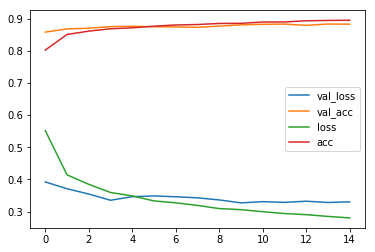

In [0]:
clf = KerasClassifier(make_sklearn_mlp, n_features=num_features,
                      n_classes=num_classes,  keep=0.9)

history_callback = clf.fit(X_train, y_train, batch_size=16, epochs=15,
                           shuffle=True, verbose=1,
                           validation_data=(X_val, y_val))
pd.DataFrame(history_callback.history).plot()

#### Looking at the above results and learning curves, we can see that whithout dropout, our model was ovefitting but dropout of 10% helped to regularize our model and improved validation accuracy results.

#### Let's now try dropping out rate of 30% (keep 70%): 

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 13s 270us/step - loss: 0.6635 - acc: 0.7647 - val_loss: 0.4138 - val_acc: 0.8513
Epoch 2/15
50000/50000 [==============================] - 12s 245us/step - loss: 0.4952 - acc: 0.8264 - val_loss: 0.3850 - val_acc: 0.8638
Epoch 3/15
50000/50000 [==============================] - 14s 271us/step - loss: 0.4577 - acc: 0.8381 - val_loss: 0.4014 - val_acc: 0.8559
Epoch 4/15
50000/50000 [==============================] - 12s 246us/step - loss: 0.4304 - acc: 0.8457 - val_loss: 0.3710 - val_acc: 0.8642
Epoch 5/15
50000/50000 [==============================] - 14s 271us/step - loss: 0.4154 - acc: 0.8495 - val_loss: 0.3760 - val_acc: 0.8635
Epoch 6/15
50000/50000 [==============================] - 12s 248us/step - loss: 0.4031 - acc: 0.8549 - val_loss: 0.3570 - val_acc: 0.8705
Epoch 7/15
50000/50000 [==============================] - 12s 246us/step - loss: 0.3976 - acc: 0.8581 - val_loss: 0.

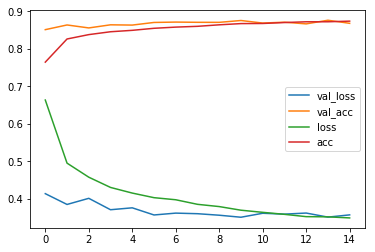

In [0]:
clf = KerasClassifier(make_sklearn_mlp, n_features=num_features,
                      n_classes=num_classes,  keep=0.7)

history_callback = clf.fit(X_train, y_train, batch_size=16, epochs=15,
                           shuffle=True, verbose=1,
                           validation_data=(X_val, y_val))
pd.DataFrame(history_callback.history).plot()


#### As we can see, increasing the dropout rate from 10% to 30%, increases regularization effect but it decreases the validation accuracy / performance of our model.



### Let's build a model using batch-normalization: 

In [0]:
def make_sklearn_mlp(n_features, n_classes):
  mlp = Sequential([
      Dense(32, input_shape=(num_features,),
            kernel_initializer = glorot_uniform(0)),
      BatchNormalization(),
      Activation('relu'),
      Dense(32,
            kernel_initializer = glorot_uniform(0)),
      BatchNormalization(),
      Activation('relu'),
      Dense(num_classes, activation='softmax',
           kernel_initializer = glorot_uniform(0))])
  mlp.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
  return mlp

#### Let's train and validate our batch-normalization model:

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 22s 430us/step - loss: 0.5931 - acc: 0.7975 - val_loss: 0.4120 - val_acc: 0.8505
Epoch 2/15
50000/50000 [==============================] - 20s 404us/step - loss: 0.4439 - acc: 0.8438 - val_loss: 0.3700 - val_acc: 0.8673
Epoch 3/15
50000/50000 [==============================] - 19s 388us/step - loss: 0.4114 - acc: 0.8513 - val_loss: 0.3792 - val_acc: 0.8594
Epoch 4/15
50000/50000 [==============================] - 21s 417us/step - loss: 0.3883 - acc: 0.8587 - val_loss: 0.3521 - val_acc: 0.8722
Epoch 5/15
50000/50000 [==============================] - 20s 391us/step - loss: 0.3743 - acc: 0.8649 - val_loss: 0.3417 - val_acc: 0.8773
Epoch 6/15
50000/50000 [==============================] - 21s 422us/step - loss: 0.3614 - acc: 0.8691 - val_loss: 0.3357 - val_acc: 0.8816
Epoch 7/15
50000/50000 [==============================] - 19s 387us/step - loss: 0.3542 - acc: 0.8726 - val_loss: 0.

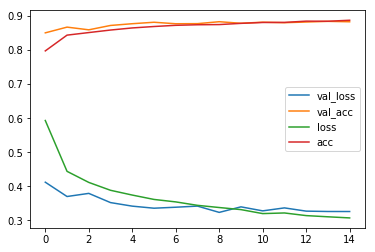

In [0]:
clf = KerasClassifier(make_sklearn_mlp, n_features=num_features,
                      n_classes=num_classes)

history_callback = clf.fit(X_train, y_train, batch_size=16, epochs=15,
                           shuffle=True, verbose=1,
                           validation_data=(X_val, y_val))
pd.DataFrame(history_callback.history).plot()

#### Looking at the above results and learning curves, we can see that, similarly to using dropout, batch-normalization helped to regularize our model and improved validation accuracy results.

### Let's build a model using residual connections:

In [0]:
 def make_sklearn_mlp(n_features, n_classes):
  mlp = Sequential([
      Dense(32, input_shape=(num_features,),
            kernel_initializer = glorot_uniform(0)),
      BatchNormalization(),
      Activation('relu'),
      Dense(32,
            kernel_initializer = glorot_uniform(0)),
      BatchNormalization(),
      Activation('relu'),
      Dense(num_classes, activation='softmax',
           kernel_initializer = glorot_uniform(0))])
  mlp.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
  return mlp

#### Some text here:

In [0]:
clf = KerasClassifier(make_sklearn_mlp, n_features=num_features,
                      n_classes=num_classes)

history_callback = clf.fit(X_train, y_train, batch_size=16, epochs=15,
                           shuffle=True, verbose=1,
                           validation_data=(X_val, y_val))
pd.DataFrame(history_callback.history).plot()

<h2> Task 3 - Train a convolutional neural network
  
 <h3>  Let's perform all necessary steps to download the dataset from Kaggle into Google's Colab, using Kaggle CLI:

In [0]:
# Install Kaggle CLI:
!pip install kaggle

In [0]:
# Authorize Colab to access Kagle by importing kaggle.json from google drive:
# This snippet will output a link which needs authentication from google account
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


#### List all Kaggle datasets with the keyword 'Histopathology':

In [0]:
!kaggle datasets list -s Histopathology

ref                                             title                            size  lastUpdated          downloadCount  
----------------------------------------------  -------------------------------  ----  -------------------  -------------  
paultimothymooney/breast-histopathology-images  Breast Histopathology Images      1GB  2017-12-19 05:46:40           4316  
kmader/skin-cancer-mnist-ham10000               Skin Cancer MNIST: HAM10000       3GB  2018-09-20 20:36:13           7667  
tywangty/histopathologiccancerwsi               histopathologic-cancer-WSI        5MB  2019-03-14 13:21:16             27  
discdiver/mnist1000-with-one-image-folder       MNIST1000_with_one_image_folder   3GB  2019-03-20 17:30:54             27  


#### Download the dataset to Google's Colab:

In [0]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

 98% 1.47G/1.49G [00:13<00:00, 129MB/s]
100% 1.49G/1.49G [00:13<00:00, 119MB/s]


#### Let's check the name of the dowloaded file:

In [0]:
#import os

os.listdir()

['.config',
 'adc.json',
 'data',
 'IDC_regular_ps50_idx5.zip',
 'breast-histopathology-images.zip',
 'sample_data']

#### Let's unzip 'breast-histopathology-images.zip' and check unzipped files:

In [0]:
!unzip breast-histopathology-images.zip
os.remove('breast-histopathology-images.zip')
os.listdir()

['.config', 'adc.json', 'data', 'IDC_regular_ps50_idx5.zip', 'sample_data']

#### Let's unzip 'IDC_regular_ps50_idx5.zip' into a folder named 'data':

In [0]:
#from zipfile import ZipFile 
  
file_name = 'IDC_regular_ps50_idx5.zip'
with ZipFile(file_name, 'r') as zip: 
    print('Unzipping...') 
    zip.extractall('data') 
    print('Done Unzipping!') 
os.remove('IDC_regular_ps50_idx5.zip')
os.listdir()

['.config', 'adc.json', 'data', 'sample_data']

#### Let's check the content of the 'data' Dir: 

In [0]:
os.listdir('./data')

['12810',
 '9076',
 '8956',
 '9178',
 '8959',
 '12951',
 '10259',
 '14191',
 '12869',
 '9291',
 '12894',
 '12934',
 '12626',
 '14211',
 '14154',
 '14212',
 '12892',
 '10293',
 '14189',
 '9383',
 '9228',
 '9125',
 '9175',
 '13616',
 '15839',
 '15634',
 '16569',
 '10286',
 '9257',
 '10253',
 '16552',
 '9258',
 '12820',
 '13591',
 '15513',
 '16568',
 '14305',
 '13693',
 '9075',
 '9266',
 '14082',
 '9181',
 '16895',
 '14081',
 '12881',
 '14192',
 '15472',
 '8863',
 '12954',
 '9174',
 '8975',
 '12891',
 '10306',
 '12752',
 '13403',
 '12900',
 '10268',
 '8957',
 '10257',
 '9177',
 '12821',
 '13402',
 '9225',
 '9262',
 '13025',
 '9035',
 '8865',
 '13694',
 '9254',
 '10305',
 '9227',
 '15632',
 '12811',
 '9173',
 '8864',
 '8918',
 '12907',
 '12884',
 '8951',
 '10282',
 '10307',
 '10308',
 '10261',
 '16555',
 '10295',
 '16014',
 '10290',
 '9261',
 '12905',
 '14078',
 '10260',
 '10302',
 '13458',
 '14321',
 '12890',
 '15633',
 '12819',
 '9073',
 '8913',
 '13106',
 '13691',
 '8950',
 '14156',
 '1

#### There are several folders which, according to the metadata, each folder would correspond to a patient ID.

#### Inside each patient ID's folder, there are 2 sub-folders named '0'  and '1', where '0' stores the images with no IDC (I'nvasive Ductal Carcinoma' breast cancer) and '1' stores images with IDC:

In [0]:
os.listdir('./data/12810')

['1', '0']

In [0]:
print('\nFirst five (5) non-IDC images for patient ID ¨12810¨:')
for img in os.listdir('./data/12810/0')[:5]:
  print('  *', img)

print('\nFirst five (5) IDC images for patient ID ¨12810¨:')
for img in os.listdir('./data/12810/1')[:5]:
  print('  *', img)


First five (5) non-IDC images for patient ID ¨12810¨:
  * 12810_idx5_x1751_y451_class0.png
  * 12810_idx5_x2901_y2951_class0.png
  * 12810_idx5_x1451_y751_class0.png
  * 12810_idx5_x1151_y401_class0.png
  * 12810_idx5_x1101_y2551_class0.png

First five (5) IDC images for patient ID ¨12810¨:
  * 12810_idx5_x1701_y901_class1.png
  * 12810_idx5_x2001_y1051_class1.png
  * 12810_idx5_x1351_y801_class1.png
  * 12810_idx5_x1901_y1151_class1.png
  * 12810_idx5_x1101_y1001_class1.png


In [0]:
from urllib.request import urlretrieve
import os

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

download('https://www.kaggle.com/paultimothymooney/breast-histopathology-images/downloads/breast-histopathology-images.zip/1','breast_cancer2.zip')

try:
  os.system('7z x breast_cancer.zip')
except Exception as e:
  print(e)

Download file... breast_cancer2.zip ...
File downloaded


In [0]:
try:
  !7z e breast_cancer.zip
  print('unnzipped')
  
except Exception as e:
  print(e)


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 8543 bytes (9 KiB)

Extracting archive: breast_cancer.zip
ERROR: breast_cancer.zip
breast_cancer.zip
Open ERROR: Can not open the file as [zip] archive


ERRORS:
Is not archive
  0%    
Can't open as archive: 1
Files: 0
Size:       0
Compressed: 0
unnzipped


#### Let's plot to see if there is any visually preceptible one-to-one relationship between the target and the newly derived features:

In [0]:
os.system( '7z x breast_cancer.zip -oPath/to/Name' )

512

#### It seems like these newly derived features do not encode much information about the target. Let's add them as additional features to our base model and see it it performs better:

In [0]:
X_train = bag.fit_transform(text_train)
X_train

In [0]:
new_features = df[new_cols]
X_train = hstack((X_train, new_features))
X_train

### Let's evaluate our baseline model with these newly added features:

In [0]:
lr = LogisticRegressionCV(scoring="roc_auc", random_state=0).fit(X_train, y_train)
auc_roc_derived_features = lr.scores_[1].mean(axis=0).max()
print ('\nMax auc_roc baseline model: {:.8f}'.format(auc_roc_baseline))
print ('Max auc_roc with newly derived features: {:.8f}'.format(auc_roc_derived_features))

#### Result didn't improve. 

### Let's now explore some other features we think may be important for this speficic task:

In [0]:
some_bad_strings = ['shit','fuck','dam','mother','father','dad','hate','sex'] # strings in bad words
offense_words = ['you','your','they','their','our','ours','mom', 'comment'] # frequently used in offensive responses

bad_words = lambda x: len([word for bad in some_bad_strings for word in x['body'].split() if bad in str.lower(word)])
offensive = lambda x: len([word for offense in offense_words for word in x['body'].split() if offense == str.lower(word)])

df = df[['body', 'REMOVED']]
df['bad_words'] = df.apply(bad_words, axis=1)
df['offensive'] = df.apply(offensive, axis=1)
print(df[:20])

#### Let's add these newly derived features to our base model and see it it performs better:

In [0]:
X_train = bag.fit_transform(text_train)
X_train

In [0]:
new_cols = ['bad_words', 'offensive']
new_features = df[new_cols]
X_train = hstack((X_train, new_features))
X_train

In [0]:
lr = LogisticRegressionCV(scoring="roc_auc", random_state=0).fit(X_train, y_train)
auc_roc_derived_features = lr.scores_[1].mean(axis=0).max()
print ('\nMax auc_roc baseline model: {:.8f}'.format(auc_roc_baseline))
print ('Max auc_roc with newly derived features: {:.8f}'.format(auc_roc_derived_features))

#### It worked this time!

#### Though a very small improvement, we can see that adding the count of bad words and words we think are frequently used in offensive responses, slightly increases the performance of our classifier, using the same random state. 

<h2 >Task 2 - Word Vectors

### Use a pretrained word-embedding (word2vec, glove or fasttext) instead of the bag-of-words model.

#### Let's use Google's Word2Vect pre-trained model:

In [0]:
import gensim as gensim

W2V = gensim.models.KeyedVectors.load_word2vec_format('./Models/GoogleNews-vectors-negative300.bin', binary=True)

#### Let's get each document in our training dataset as a list of tokens for W2V model: 

In [0]:
vect_w2v = CountVectorizer(vocabulary=W2V.index2word)
vect_w2v.fit(text_train)
docs = vect_w2v.inverse_transform(vect_w2v.transform(text_train))
docs[0]

#### Now for each document, we will replace each tokens in the document by a 300-dimensional vector, then represent each document by the mean of all the 300-dimensional vectors:

In [0]:
try:
    X_train = np.vstack([np.mean(W2V[doc], axis=0) for doc in docs])
    X_train.shape
except Exception as e:
    print('Got error/exception:', e)

#### We are getting an error: Let's see what is going on in the docs where we are getting that error:

In [0]:
removed = 0
non_removed = 0
for i in range (len(docs)):
    try:
        W2V[docs[i]]
    except Exception as e:
        if df['REMOVED'][i] == True:
            removed+=1
        else: non_removed+=1    
        print(i, text_train[i], 'REMOVED?:', df['REMOVED'][i])
print('\nn_removed: {},  n_non_removed: {}'.format(removed, non_removed))

#### As we can see above, the error is taking place in documents wehre there is not a single recognizable word (not a single word that makes sense). So let's replace all those documents with the token 'UNK': 

In [0]:
text_train_repaired = []   
for i in range (len(docs)):
    try:
        W2V[docs[i]]
        text_train_repaired.append(text_train[i])
    except Exception as e:
        text_train_repaired.append('UNK')

#### Let's go back and get each document in our repaired training dataset as a list of tokens for W2V model: 

In [0]:
vect_w2v = CountVectorizer(vocabulary=W2V.index2word)
vect_w2v.fit(text_train_repaired)
docs = vect_w2v.inverse_transform(vect_w2v.transform(text_train_repaired))
docs[0]

#### Now for each document, we will replace each tokens in the document by a 300-dimensional vector, then represent each document by the mean of all the 300-dimensional vectors (should work this time):

In [0]:
X_train = np.vstack([np.mean(W2V[doc], axis=0) for doc in docs])
X_train.shape

#### It worked!

#### Let's now see what results we get using the pretrained word2vec as compared with the baseline bag-of-words model:

In [0]:
lr = LogisticRegressionCV(scoring="roc_auc", random_state=0).fit(X_train, y_train)
auc_roc_w2v = lr.scores_[1].mean(axis=0).max()
print ('\nMax auc_roc baseline bag-of-words model : {:.8f}'.format(auc_roc_baseline))
print ('\nOur best model auc_roc (using character n-grams): {:.8f}'.format(auc_roc_char_ngrams))
print ('\nMax auc_roc using pretrained word2vec: {:.8f}'.format(auc_roc_w2v))

### Does this improve classification?

Using a a pretrained word-embedding (word2vec) instead of the bag-of-words model didn't improve classification but we got an auc_roc of 0.7279, somewhat close to our baseline bag-of-words mode where we got an auc_roc of 0.7593, though far from our best result using character n-grams with an auc_roc of 0.7915